## Waterway (Unsupervised)

In [1]:
# libs
from __future__ import division
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.transform import rescale, resize
import pandas as pd
import cv2
from helpers import Helper
import os
import shapely
from shapely.geometry import MultiPolygon, Polygon

In [2]:
data = pd.read_csv('../input/train_wkt_v4.csv')
data = data[data.MultipolygonWKT != 'MULTIPOLYGON EMPTY']
grid_sizes_fname = '../input/grid_sizes.csv'
wkt_fname = '../input/train_wkt_v4.csv'
image_fname = '../input/three_band/'

In [3]:
def stretch_8bit(bands, lower_percent=2, higher_percent=98):
    out = np.zeros_like(bands).astype(np.float32)
    for i in range(3):
        a = 0 
        b = 1 
        c = np.percentile(bands[:,:,i], lower_percent)
        d = np.percentile(bands[:,:,i], higher_percent)        
        t = a + (bands[:,:,i] - c) * (b - a) / (d - c)    
        t[t<a] = a
        t[t>b] = b
        out[:,:,i] =t
    return out.astype(np.float32)

def calc_jac(pred, label):
    itersec = np.multiply(pred, label).sum()
    summ = (pred+label).sum()
    jac = itersec/(summ-itersec)
    return jac

def ODS_index(m, rgb):
    RE  = resize(m[5,:,:], (rgb.shape[0], rgb.shape[1]), preserve_range=True)
    MIR = resize(m[7,:,:], (rgb.shape[0], rgb.shape[1]), preserve_range=True) 
    ODS_index = (RE-MIR)/(MIR+RE)
    return ODS_index   

# waterway
def predict_id(IM_ID, mode='train'):
    helper = Helper()
    img_rgb, size = helper.load_tiff_img('../input/three_band/', IM_ID)
    m = tiff.imread('../input/sixteen_band/{}_M.tif'.format(IM_ID))
    CCCI = ODS_index(m, img_rgb)    
    binary = (CCCI > 0.16).astype(np.float32)
    print 'number of pixels:', binary.sum()

    if mode == 'test':
        if binary.sum() < 100000:
            return "MULTIPOLYGON EMPTY"
    
    # find contours with open cv
    image, contours, hierarchy = cv2.findContours((255*(binary==1)).astype(np.uint8),
                                                  cv2.RETR_CCOMP,
                                                  cv2.CHAIN_APPROX_TC89_KCOS)    

    cv = cv2.drawContours(image, contours, -1, (255,225,255), 5)

    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 20))
    ax = axes.ravel()

    ax[0].imshow(stretch_8bit(img_rgb))
    ax[0].set_title('Image')
    ax[0].axis('off')
    ax[1].imshow(binary)
    ax[1].set_title('Binary')
    ax[1].axis('off')
    ax[2].imshow(cv)
    ax[2].set_title('CV')
    ax[2].axis('off')
    plt.tight_layout()
    plt.show()

    helper.pred_polygons = helper.mask_to_polygons(binary, epsilon=1, min_area=5000, 
                                                   max_area=500000000000, 
                                                   buffer_value=0)  
    x_max, y_min = helper.get_grid_sizes(IM_ID, grid_sizes_fname)    
    helper.scale_polygons(x_max, y_min, size, scale_in=False)  
    
    if mode == 'train':
        return binary, helper.pred_polygons_scaled
    elif mode == 'test':
        return helper.pred_polygons_scaled

## Train images

/home/home/scikit-image/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


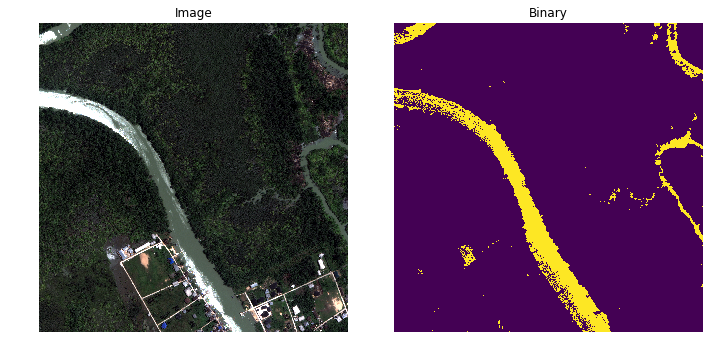

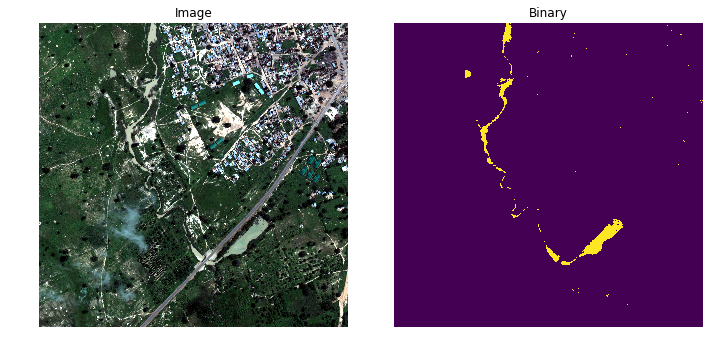

In [4]:
for IM_ID in data[data.ClassType == 7].ImageId:
    # read rgb and m bands
    rgb = tiff.imread('../input/three_band/{}.tif'.format(IM_ID))
    rgb = np.rollaxis(rgb, 0, 3)
    m = tiff.imread('../input/sixteen_band/{}_M.tif'.format(IM_ID))
    
    # get our index
    CCCI = ODS_index(m, rgb) 
    
    # you can look on histogram and pick your favorite threshold value(0.11 is my best)
    binary = (CCCI > 0.16).astype(np.float32)
    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 10))
    ax = axes.ravel()
    ax[0].imshow(stretch_8bit(rgb))
    ax[0].set_title('Image')
    ax[0].axis('off')
    ax[1].imshow(binary)
    ax[1].set_title('Binary')
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()
    

## Check jaccard

number of pixels: 848153.0


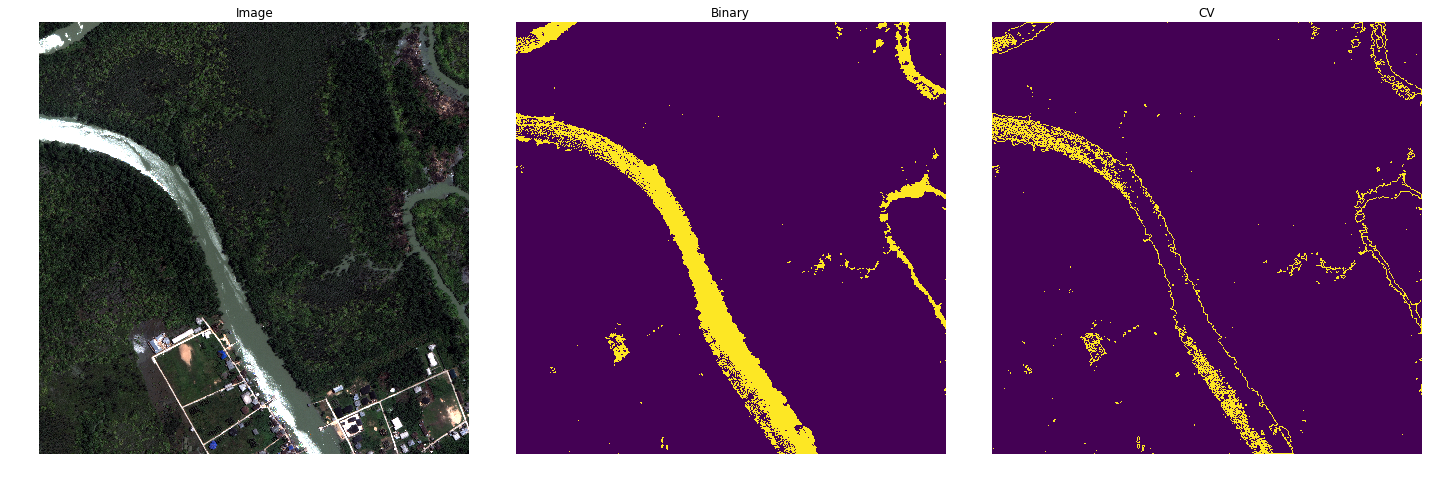

Self-intersection at or near point 2079.818181818182 3250.2727272727275


mask jaccard: 0.657070327996
final jaccard: 0.656379485377
prediction size: 195,823 bytes
number of pixels: 153782.0


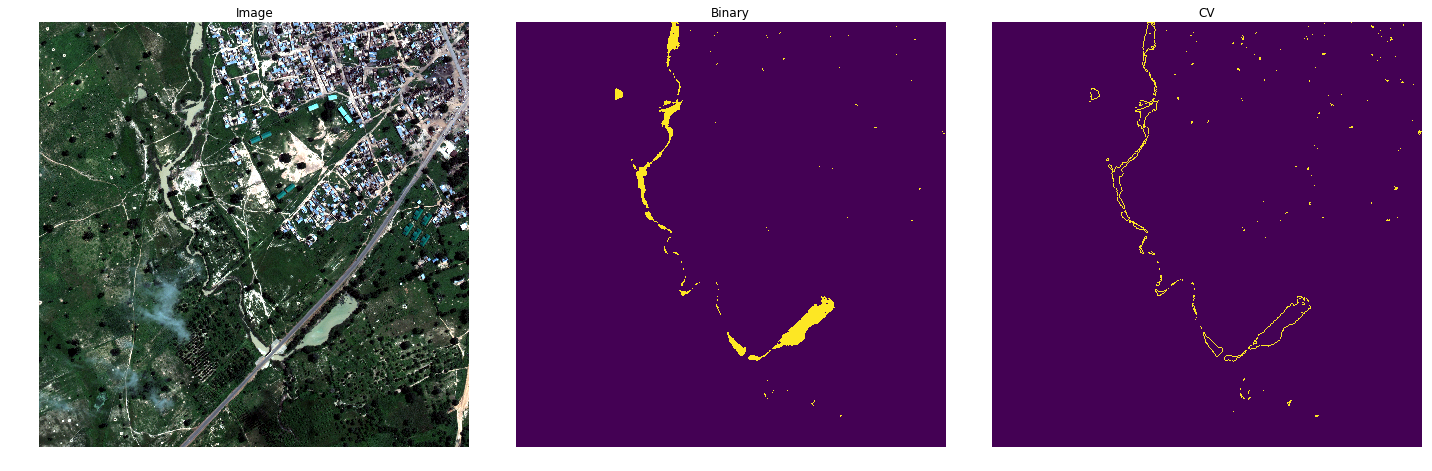

mask jaccard: 0.636456679482
final jaccard: 0.59309603614
prediction size: 26,633 bytes


In [5]:
for IM_ID in data[data.ClassType == 7].ImageId:
    helper = Helper()
    img_rgb, mask = helper.load_im_polymask(IM_ID, '7', image_fname, wkt_fname, grid_sizes_fname)
    
    # predict full image mask
    mask_new, mask_scaled=predict_id(IM_ID, mode='train')
    dumped_prediction = shapely.wkt.dumps(mask_scaled)
    final_poly = shapely.wkt.loads(dumped_prediction)

    # info
    jac = calc_jac(mask_new, mask)
    fin = final_poly.intersection(helper.train_polygons).area / final_poly.union(helper.train_polygons).area

    print 'mask jaccard:', jac
    print 'final jaccard:', fin
    print 'prediction size: {:,} bytes'.format(len(dumped_prediction))

## Test images

In [ ]:
# take some pictures from test 
waterway_test = ['6080_4_3', '6050_1_4', '6080_4_0', 
              '6080_1_3', '6080_1_1', '6150_3_4',
              '6050_2_4', '6050_2_1', '6070_3_4',
              '6050_0_0', '6080_0_4', '6080_1_2',
              '6070_4_2', '6070_1_1', '6050_0_4', 
              '6070_0_2', '6050_2_0', '6070_1_4',
              '6050_3_3', '6030_4_3', '6080_1_4', 
              '6050_2_3', '6070_4_0', '6080_3_3',
              '6070_2_2', '6070_1_3', '6080_3_2',
              '6050_3_4', '6080_3_1', '6070_3_1', 
              '6080_3_0', '6050_1_0', '6080_2_4',
              '6070_0_1', '6030_4_4', '6080_2_3', 
              '6080_3_4', '6030_3_4', '6070_0_3', 
              '6150_4_3', '6070_2_1', '6070_4_4',
              '6080_2_2', '6080_0_3', '6050_0_1',
              '6080_4_2', '6050_2_2', '6050_3_2',
              '6080_0_0', '6150_4_4', '6070_4_1',
              '6070_0_0', '6050_4_3', '6070_3_3',
              '6050_4_4', '6070_3_2', '6070_4_3', 
              '6030_2_4', '6080_4_1', '6050_4_2', 
             ]


for IM_ID in waterway_test:
    # read rgb and m bands
    rgb = tiff.imread('../input/three_band/{}.tif'.format(IM_ID))
    rgb = np.rollaxis(rgb, 0, 3)
    m = tiff.imread('../input/sixteen_band/{}_M.tif'.format(IM_ID))
    
    # get our index
    CCCI = ODS_index(m, rgb) 
    binary = (CCCI > 0.16).astype(np.float32)
    print binary.sum()
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 10))
    ax = axes.ravel()
    ax[0].imshow(stretch_8bit(rgb))
    ax[0].set_title('Image')
    ax[0].axis('off')
    ax[1].imshow(binary)
    ax[1].set_title('Binary')
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

## Predict

In [ ]:
def make_submit():
    print "make submission file"
    df = pd.read_csv('../input/sample_submission.csv')

    counter = 1 
    for idx, row in df[df.ClassType == 7].iterrows():
        _id = row[0]
        kls = row[1] - 1
        
        result = predict_id(_id, mode='test')
        if result == 'MULTIPOLYGON EMPTY':
            df.iloc[idx, 2] = 'MULTIPOLYGON EMPTY'
        else:
            df.iloc[idx, 2] = shapely.wkt.dumps(result)
        
        print counter
        counter += 1
            
    print df.head()
    df.to_csv('1.csv', index=False)

In [ ]:
make_submit()

In [ ]:
df = pd.read_csv('1.csv')

for idx, row in df[df.ClassType != 7].iterrows():
    _id = row[0]
    kls = row[1] - 1
    df.iloc[idx, 2] = 'MULTIPOLYGON EMPTY'

print df.head()
df.to_csv('waterway_500k.csv', index=False)